In [1]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
#parameters
g = 9.81
vt = 4.9
CD = 1.0 / 5.0
CL = 1.0

#IC
v0 = 6.5
theta0 = -0.1
x0 = 0.0
y0 = 2.0

In [5]:
def rhs_phugoid(u, CL, CD, g, vt):
    """
    Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : list or numpy.ndarray
        Solution at the previous time step
        as a list or 1D array of four floats.
    CL : float
        Lift coefficient.
    CD : float
        Drag coefficient.
    g : float
        Gravitational acceleration.
    vt : float
        Trim velocity.
    
    Returns
    -------
    rhs : numpy.ndarray
        The right-hand side of the system
        as a 1D array of four floats.
    """
    v, theta, x, y = u
    rhs = numpy.array([-g * math.sin(theta) - CD / CL * g / vt**2 * v**2,
                       -g * math.cos(theta) / v + g / vt**2 * v,
                       v * math.cos(theta),
                       v * math.sin(theta)])
    return rhs


def euler_step(u, f, dt, *args):
    """
    Returns the solution at the next time step using Euler's method.
    
    Parameters
    ----------
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_new = u + dt * f(u, *args)
    return u_new


def l1_diff(u_coarse, u_fine, dt):
    """
    Returns the difference in the L1-norm between the solution on
    a coarse grid and the solution on a fine grid.
    
    Parameters
    ----------
    u_coarse : numpy.ndarray
        Solution on the coarse grid as a 1D array of floats.
    u_fine : numpy.ndarray
        Solution on the fine grid as a 1D array of floats.
    dt : float
        Time-step size.
    
    Returns
    -------
    diff : float
        The difference between the two solution in the L1-norm
        scaled by the time-step size.
    """
    N_coarse = u_coarse.shape[0]
    N_fine = u_fine.shape[0]
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt * numpy.sum(numpy.abs(u_coarse - u_fine[::ratio]))
    return diff

In [6]:
def rk2_step(u, f, dt, *args):
    u_star = u + 0.5 * dt * f(u, *args)
    u_new = u + dt * f(u_star, *args)
    return u_new

In [9]:
T = 15.0
dt = 0.01
N = int(T / dt) + 1

u_euler = numpy.empty((N, 4))
u_rk2 = numpy.empty((N, 4))

u_euler[0] = numpy.array([v0, theta0, x0, y0])
u_rk2[0] = numpy.array([v0, theta0, x0, y0])

for n in range(N - 1):
    u_euler[n + 1] = euler_step(u_euler[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_rk2[n + 1] = rk2_step(u_rk2[n], rhs_phugoid, dt, CL, CD, g, vt)

In [10]:
x_euler = u_euler[:, 2]
y_euler = u_euler[:, 3]
x_rk2 = u_rk2[:, 2]
y_rk2 = u_rk2[:, 3]

In [13]:
idx_negative_euler = numpy.where(y_euler < 0.0)[0]
if len(idx_negative_euler) == 0:
    idx_ground_euler = N - 1
    print('[Euler] Glider has not touched ground yet!')
else:
    idx_ground_euler = idx_negative_euler[0]

idx_negative_rk2 = numpy.where(y_rk2 < 0.0)[0]
if len(idx_negative_rk2) == 0:
    idx_ground_rk2 = N - 1
    print('[RK2] Glider has not touched ground yet!')
else:
    idx_ground_rk2 = idx_negative_rk2[0]

In [14]:
# Check if to two scheme leads to the same numerical solution.
print('Are the x-values close? {}'.format(numpy.allclose(x_euler, x_rk2)))
print('Are the y-values close? {}'.format(numpy.allclose(y_euler, y_rk2)))

Are the x-values close? False
Are the y-values close? False


Distance traveled: 14.516


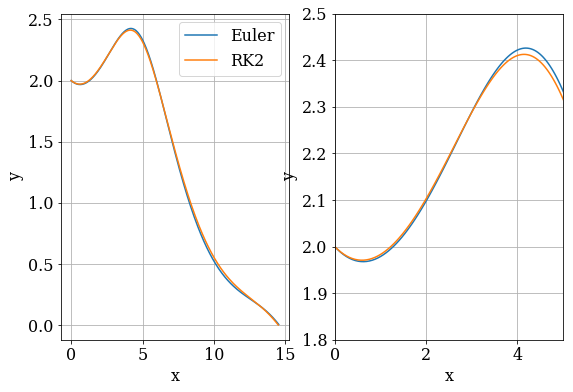

In [15]:
print('Distance traveled: {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))

pyplot.figure(figsize=(9.0,6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
           label='Euler')
pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2], label='RK2')
pyplot.legend();
pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler, y_euler, label='Euler')
pyplot.plot(x_rk2, y_rk2, label='RK2')
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

In [20]:
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)

In [21]:
diff_values = []
for u, dt in zip(u_values, dt_values):
    diff = l1_diff(u[:,2], u_values[-1][:, 2], dt)
    diff_values.append(diff)

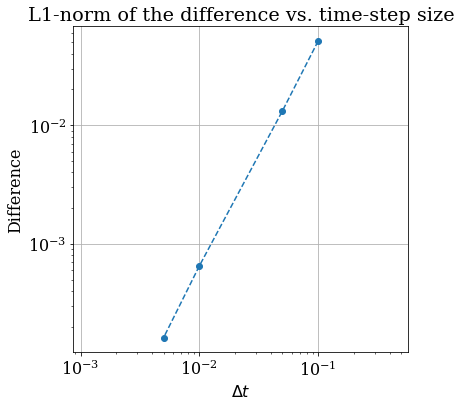

In [24]:
pyplot.figure(figsize=(6.0, 6.0))
pyplot.title('L1-norm of the difference vs. time-step size')
pyplot.xlabel('$\Delta t$')
pyplot.ylabel('Difference')
pyplot.grid()
pyplot.loglog(dt_values[:-1], diff_values[:-1],
              color='C0', linestyle='--', marker='o')
pyplot.axis('equal');

In [25]:
r = 2
h = 0.001

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) +1
    u = numpy.empty((N,4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    for n in range(N-1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)
        
p = (math.log(l1_diff(u_values[2], u_values[1], dt_values[2]) /
             l1_diff(u_values[1], u_values[0], dt_values[1])) /
    math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 1.996


In [26]:
#Leap Frog Method

In [27]:
def leapfrog_step(u_prev, u, f, dt, *args):
    u_new = u_prev + 2.0 * dt * f(u,*args)
    return u_new

In [33]:
# Set parameters.
g = 9.81  # gravitational acceleration (m.s^{-2})
vt = 4.9  # trim velocity (m.s)
CD = 1.0 / 5.0  # drag coefficient
CL = 1.0  # lift coefficient

# Set initial conditions.
v0 = 6.5  # start at the trim velocity
theta0 = -0.1  # trajectory angle
x0 = 0.0  # horizontal position
y0 = 25.0  # vertical position (altitude)

T = 36.0  # length of the time interval
dt = 0.01  # time-step size
N = int(T / dt) + 1  # number of time steps

# Create arrays to store the solution at each time step.
u_leapfrog = numpy.empty((N, 4))
# Set the initial conditions.
u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])
# Use the RK2 method for the first time step.
u_leapfrog[1] = rk2_step(u_leapfrog[0], rhs_phugoid, dt, CL, CD, g, vt)

In [34]:
for n in range(1, N-1):
    u_leapfrog[n + 1] = leapfrog_step(u_leapfrog[n-1], u_leapfrog[n],
                                     rhs_phugoid, dt, CL, CD, g, vt)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars


ValueError: math domain error

In [35]:
# Get the glider's position over the time.
x_leapfrog = u_leapfrog[:, 2]
y_leapfrog = u_leapfrog[:, 3]

# Get the index of the first negative element of y_leapfrog.
idx_negative_leapfrog = numpy.where(y_leapfrog < 0.0)[0]
if len(idx_negative_leapfrog) == 0:
    idx_ground_leapfrog = N - 1
    print('[leapfrog] Glider has not touched ground yet!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

Distance traveled: 123.917


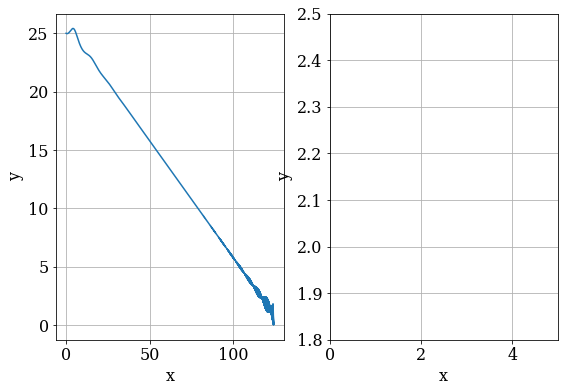

In [36]:
print('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog - 1]))

# Plot the glider's path for the leapfrog scheme.
pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog],
            y_leapfrog[:idx_ground_leapfrog])
# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog, y_leapfrog)
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

In [37]:
r = 2  # time-step size refinement ratio
h = 0.001  # finest time-step size

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1  # number of time steps
    # Set initial conditions.
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    # Use RK2 for the first time step.
    u[1] = rk2_step(u[0], rhs_phugoid, dt, CL, CD, g, vt)
    # Time integration using the leapfrog scheme.
    for n in range(1, N - 1):
        u[n + 1] = leapfrog_step(u[n - 1], u[n], rhs_phugoid, dt,
                                 CL, CD, g, vt)
    # Store the solution for the present time grid.
    u_values.append(u)

# Compute the observed order of convergence.
p = (math.log(l1_diff(u_values[2][:, 2], u_values[1][:, 2],
                      dt_values[2]) /
              l1_diff(u_values[1][:, 2], u_values[0][:, 2],
                      dt_values[1])) /
     math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 4.181
